*Note: I found a small bug in pymc (with `TruncatedNormal`) while writing this notebook, so you will need to install the latest development version of the package in order for the examples to complete successfully. You can install the development version with `pip`*:

    pip install git+https://github.com/pymc-devs/pymc

In [1]:
import pathlib

import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import daft
from pyia import GaiaData
import arviz as az
import pymc as pm

# Hierarchical Models 1

*By [Adrian Price-Whelan](https://adrian.pw/)*

Most of the probabilistic models we have discussed so far have been *one-level* models: In these cases, the data are generated by some functional model that has parameters, and those parameters are random variables assumed to be drawn from fixed prior probability distributions. Hierarchical models are also called *multi-level* models because they take these ideas and expand and generalize them to consider models that may have multiple levels or layers of random variables that generate the data. For example, if we have data $D$ and some parameters $\theta$, in a one-level model the join distribution $p(D, \theta)$ is often factorized as:

$$
p(D, \theta) = p(D | \theta) \, p(\theta)
$$

where $p(D | \theta)$ is the "likelihood" and $p(\theta)$ is the "prior."

In a multi-level model, the parameters closest to the data, $\theta$, are themselves generated by some stochastic process that is governed by another set of random variables or parameters known as "hyper-parameters," sometimes denoted as $\alpha$. In such a case, the joint probability could be factorized as:

$$
p(D, \theta, \alpha) = p(D | \theta) \, p(\theta | \alpha) \, p(\alpha)
$$

Note that in this case (and as is often the case), the data only depends on $\alpha$ through the relationship between $\theta$ and $\alpha$, but this is not a requirement. A graphical model for this (general) case would look like:

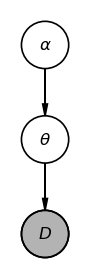

In [2]:
pgm = daft.PGM(dpi=120)

pgm.add_node("data", "$D$", 0, 0, observed=True)
pgm.add_node("theta", r"$\theta$", 0, 1)
pgm.add_node("alpha", r"$\alpha$", 0, 2)

pgm.add_edge("theta", "data")
pgm.add_edge("alpha", "theta")

pgm.render();

In astronomy, you will frequently see "population models" of this form in which the $\theta$ variables are parameters that exist for each object in the population, and the $\alpha$ parameters are parameters of the population distribution — in these cases, using our very general terminology from above, there would be a plate around $\theta$ and $D$: 

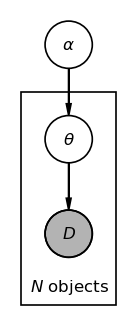

In [3]:
pgm = daft.PGM(dpi=120)

pgm.add_node("data", "$D$", 0, 0, observed=True)
pgm.add_node("theta", r"$\theta$", 0, 1)
pgm.add_node("alpha", r"$\alpha$", 0, 2)

pgm.add_edge("theta", "data")
pgm.add_edge("alpha", "theta")

pgm.add_plate([-0.5, -0.75, 1, 2.25], label="$N$ objects")

pgm.render();

There are many examples of population models like this in the literature, but to name a few that can be thought of as hierarchical population models:
- **Exoplanet (or binary-star) period or eccentricity distribution**: Here the raw data is usually light curves with transits or eclipses, but the parameters one wants to know are the properties of the period distribution or eccentricity distribution of the systems. A model therefore has the true period/eccentricity for each system, but then some parameters that govern the distribution of periods/eccentricities.
- **Velocity dispersion of a galaxy cluster**: Here the observed data are redshifts of members of a galaxy cluster, but one wants to know the velocity dispersion of the cluster. One way of doing this inference would be to construct a hierarchical model that predicts redshifts given the mean velocity and dispersion of a galaxy cluster by simultaneously inferring the true velocity of each member galaxy given its (noisy) redshift measurement.
- **Color–magnitude fitting / stellar population modeling**: The observed data here are the magnitudes of stars in a number of photometric bands, and maybe also spectroscopic parameters, and the parameters one wants to infer are properties of the stellar population like the distribution of ages, metallicities, and stellar evolutionary stages.

*Note: Implementations of and solutions to these types of inference problems aren't always expressed as hierarchical models because of computational limitations or because there are other ways of simplifying the models.*

One simple example of a hierarchical model was introduced at the end of the Probabilistic Graphical Models (PGMs) notebook — let's return to this example in more detail and demonstrate an implementation of this model.


## Example: The mean distance of a (simulated) star cluster

Returning to the example we saw at the end of the Probabilistic Graphical Model (PGM) tutorial, to recap: We are given measurements of the parallaxes (and uncertainties) for a collection of stars that we are confident are members of a star cluster, and we want to infer the mean distance to and size of the star cluster as modeled as a Gaussian. 

Let's start by generating a simulated dataset that matches this problem setup:

In [4]:
rng = np.random.default_rng(seed=42)
N = 256

sim_data = at.QTable()

# we generate the true distances from a Gaussian and convert to parallax values:
true_sc_dist = 500 * u.pc
true_sc_std = 8.7 * u.pc
true_sc_star_dist = rng.normal(true_sc_dist.value, true_sc_std.value, size=N) * true_sc_dist.unit
sim_data["parallax"] = true_sc_star_dist.to(u.mas, u.parallax())

# heteroscedastic noise (i.e. each star has its own error bar):
sim_data["parallax_error"] = (10 ** rng.uniform(-2, -1.0, size=N)) * u.mas

# now we have to "observe" the true parallaxes with the generated uncertainties:
sim_data["parallax"] = (
    rng.normal(sim_data["parallax"].value, sim_data["parallax_error"].value)
    * sim_data["parallax"].unit
)

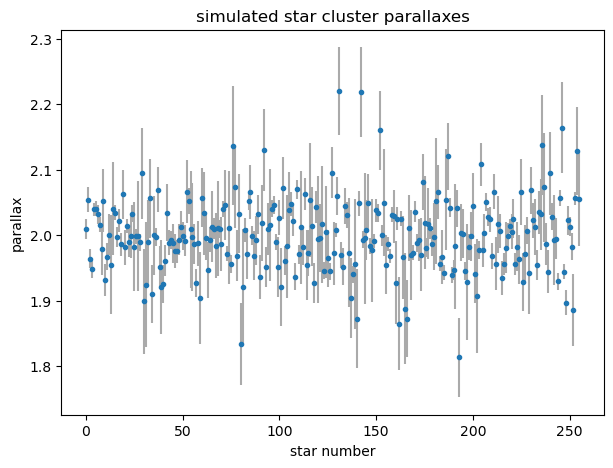

In [5]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    np.arange(len(sim_data)),
    sim_data["parallax"].value,
    yerr=sim_data["parallax_error"].value,
    ls="none",
    marker="o",
    markersize=3,
    ecolor="#aaa",
)
plt.title("simulated star cluster parallaxes")
plt.xlabel("star number")
plt.ylabel("parallax");

We now have measurements of parallaxes $\varpi_n$ for $N=256$ stars and values of the parallax uncertainty $\sigma_{\varpi, n}$ for these stars. We would like to infer the mean distance $\mu_r$ to these stars and the intrinsic size $\sigma_r$ of the star cluster, but to do this we have to also infer the true distances $r_n$ for every star in the cluster. (For notational tidiness below, let's define $\boldsymbol{r} = \{r_n\}_N$ and $\boldsymbol{\varpi} = \{\varpi_n\}_N$ to represent the sets of true distances and observed parallaxes, respectively) The thing we are ultimately after in this problem setup is the *marginal posterior pdf* for $\mu_r, \sigma_r$ given the data, or, in terms of probability distributions:

$$
p(\mu_r, \sigma_r | \boldsymbol{\varpi})
$$

But how do we get to this object? Let's start by writing down the full joint distribution for all parameters (unknown random variables) and data in our model:

$$
p(\mu_r, \sigma_r, \boldsymbol{r}, \boldsymbol{\varpi})
$$

How can we factorize this joint pdf to get to the marginal posterior pdf that we need? We can figure that out by writing down a PGM! 

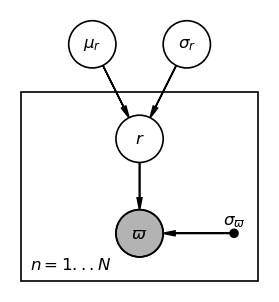

In [6]:
pgm = daft.PGM(dpi=120)

pgm.add_node("plx", r"$\varpi$", 0, 0, observed=True)
pgm.add_node("r", "$r$", 0, 1)
pgm.add_node("mu", r"$\mu_r$", -0.5, 2)
pgm.add_node("std", r"$\sigma_r$", 0.5, 2)
pgm.add_node("err", r"$\sigma_\varpi$", 1, 0, fixed=True)


pgm.add_edge("r", "plx")
pgm.add_edge("mu", "r")
pgm.add_edge("std", "r")
pgm.add_edge("err", "plx")

pgm.add_plate([-1.25, -0.5, 2.5, 2], label=r"$n = 1...N$", position="bottom left")

pgm.render();

The relationships between the random variables in the PGM above tell us that we can write:

$$
p\left(\mu_r, \sigma_r, \boldsymbol{r}, \boldsymbol{\varpi} \right) = 
    \left[ \prod_n^N p(\varpi_n | r_n) \, p(r_n | \mu_r, \sigma_r) \right] p(\mu_r) \, p(\sigma_r)
$$

In probability calculus, factorization is symmetric: We could equally well have factorized this to read

$$
p\left(\mu_r, \sigma_r, \boldsymbol{r}, \boldsymbol{\varpi}\right) = 
    p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi}) \, p(\boldsymbol{\varpi}) \quad .
$$

This factorization gets us closer to the thing we want in that $p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi})$ is a posterior pdf over all of the parameters of the model given the data.

The distribution we want is a *marginal* posterior pdf $p(\mu_r, \sigma_r | \boldsymbol{\varpi})$ because some parameters have been *marginalized out* (i.e. integrated over): the per-star true distances $\boldsymbol{r} = r_n$:

$$
p(\mu_r, \sigma_r | \boldsymbol{\varpi}) = \int \textrm{d}\boldsymbol{r} \, p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi})
$$

From setting the two factorizations above equal to one another (exactly the same way you may have used Bayes' rule), we can get the expression:

$$
p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi}) \propto
    \left[ \prod_n^N p(\varpi_n | r_n) \, p(r_n | \mu_r, \sigma_r) \right] p(\mu_r) \, p(\sigma_r)
$$

How will we integrate this expression over the $\boldsymbol{r}$'s to get to the marginal posterior pdf we want?

In some cases, it is possible to analytically marginalize (integrate) out per-object parameters. For example, if the relationship between the $r$'s and our data was linear, it would be possible to do the integral above and produce a closed-form expression that removes the hierarchical nature of this model. In this example, however, the parallax is the inverse of the distance, so the integral is not straightforward.

Instead, here we will use Markov Chain Monte Carlo (MCMC) to help with the marginalization. It turns out that if we use MCMC to generate samples from the full posterior pdf $p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi})$, and simply take the parameter chains for $\mu_r, \sigma_r$, these will be equivalent to samples of the parameters from the marginal posterior pdf $p(\mu_r, \sigma_r | \boldsymbol{\varpi})$. This is one of the most powerful aspects of MCMC!

Let's construct a model with [pymc](https://pymc.io) to do this MCMC sampling. To do this, we will need to specify (hyper)prior pdfs for $\mu_r$ and $\sigma_r$. 
- $\mu_r$: We will use a broad, truncated normal distribution with a mean of 1 kpc, a standard deviation of 2 kpc, and a minimum value of 0 (distances have to be positive!). This is a totally arbitrary choice for this example, but the idea is to be broad prior with a slight preference toward 1 kpc.
- $\sigma_r$: Here we will sample in $\ln{\sigma_r}$ and use a uniform prior on this transformed parameter, which is equivalent to putting a prior on $\sigma_r$ such that $p(\sigma_r) \propto \sigma_r^{-1}$ (this is known as a [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) for the standard deviation of a Gaussian). 

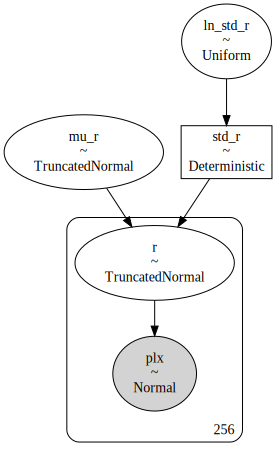

In [7]:
with pm.Model() as plx_model:
    # This is the (hyper)prior on the mean distance to the star cluster. Let's assume 
    # that we have some prior knowledge about the distance to this cluster, and so we 
    # set a broad normal distribution prior on its distance. However, we know that 
    # distances can't be negative, so we use a truncated normal distribution (truncated 
    # to values > 0) instead:
    mu_r = pm.TruncatedNormal("mu_r", mu=1.0, sigma=2.0, lower=0, upper=np.inf)
    
    # This is the (hyper)prior on ln(sigma), the log of the standard deviation of the 
    # star cluster's distance (i.e. the physical size of the cluster along the line of 
    # sight).
    ln_std_r = pm.Uniform("ln_std_r", -8, 0)
    
    # We will sample over ln(sigma), but we need the value of sigma (standard deviation)
    # to plug into the model we use for the cluster. We can transform the parameter to
    # a new un-logged value, but we need to tell pymc that this is not a new random 
    # variable: the relationship between these parameters is a deterministic tranform
    std_r = pm.Deterministic("std_r", pm.math.exp(ln_std_r))
    
    # With parameters to represent the cluster mean distance and standard deviation,
    # we can now define the model for the distances to each star. Here we will again use
    # a truncated normal distribution (r>=0). Note that we specify the "shape" of this 
    # parameter: This tells pymc to expect that we will have as many parameter values 
    # as we have len(sim_data). 
    # This line is equivalent to p(r | mu_r, sigma_r) in the math above
    r = pm.TruncatedNormal("r", mu_r, std_r, shape=len(sim_data), lower=0, upper=np.inf)
    
    # Finally, with the model-predicted individual stellar distances, we need to define
    # the relationship between our model and our data (i.e. the parallax measurements).
    # We assume that our parallax uncertainties are Gaussian, so we set up another 
    # Normal distribution (not truncated) with an expression for the model predicted 
    # parallaxes (1/r), and pass in the observed parallaxes with the "observed" keyword.
    # This line is equivalent to p(parallax | r) in the math above:
    pm.Normal(
        "plx",
        1 / r,
        observed=sim_data["parallax"].to_value(u.mas),
        sigma=sim_data["parallax_error"].to_value(u.mas),
    )
    
# Let's visualize the graphical model for this model and compare to the one above:
pm.model_to_graphviz(plx_model)

Overall, this has the same structure as the PGM we drew above! This model explicitly notes the distributions at each vertex (parameter) or when a relationship is deterministic, but otherwise this is equivalent to our PGM.

We will now fire up the `pymc` sampler to generate posterior samples of all of our parameters. When the number of parameters is large, it can be useful to start the sampler with a good initial guess for the parameter values. Of course, when working with real data, you don't know the true values used to simulate the data :), so we won't start from the true values. Here, let's initialize the distances to each star set to the inverse-variance weighted parallax of the stars:

In [8]:
inv_var = 1 / sim_data["parallax_error"] ** 2
est_mean_plx = np.sum(sim_data["parallax"] * inv_var) / np.sum(inv_var)
est_mean_r = est_mean_plx.to_value(u.kpc, u.parallax())

With these initial values in hand, we can run the sampler:

In [9]:
with plx_model:
    samples = pm.sample(
        tune=2000,
        draws=1000,
        initvals={
            "mu_r": est_mean_r,
            "ln_std_r": -3.0,
            "r": np.full(len(sim_data), est_mean_r),
        },
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_r, ln_std_r, r]


/Users/megannewsome/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 41 seconds.


*pymc may output some warnings above — you can ignore these!*

The first thing I like to check after running a pymc sampling is to use [arviz](https://python.arviz.org/en/latest/) to output a summary of sampling statistics for the run. Here we have a lot of parameters (the full vector of $r$ values is >3000 parameters!), so I will restrict the summary output to only include the hierarchical parameters:

In [10]:
# the "~r" below means "not r"
az.summary(samples, var_names=['~r'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_r,0.500,0.001,0.499,0.502,0.000,0.000,5283.0,3424.0,1.0
ln_std_r,-4.785,0.075,-4.916,-4.639,0.002,0.001,1821.0,2756.0,1.0
std_r,0.008,0.001,0.007,0.010,0.000,0.000,1821.0,2756.0,1.0


There is a lot to unpack here, but these are all useful statistics computed from the samples that allow us to assess whether the sampling was successful. The first two columns show the mean and standard deviation (sd) of the parameter value, and the following two show the "highest density interval" values (this is one version of a *credible region* estimated from the posterior samples). We won't talk about the next few columns, but MCSE is short for "Monte Carlo Standard Error" and ESS is short for "Effective Sample Size." These are both important diagnostics for assessing the quality of the samples returned. The final column `r_hat` (in math, $\hat{R}$) is the Gelman–Rubin convergence statistic (which you generally want to be fairly close to 1). Some more information about convergence diagnostics is available [in this book chapter](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html) or [this coursera course](https://www.coursera.org/lecture/introduction-to-pymc3/autocorrelation-and-effective-sample-size-YSW3x).

By the way, we could show just a few of the $r$ values by making a selection with the `coords` argument, for example, to show the first 5 values of $r$:

In [11]:
az.summary(samples, coords={"r_dim_0": np.arange(5)})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_r,0.500,0.001,0.499,0.502,0.000,0.000,5283.0,3424.0,1.00
ln_std_r,-4.785,0.075,-4.916,-4.639,0.002,0.001,1821.0,2756.0,1.00
r[0],0.498,0.003,0.492,0.504,0.000,0.000,7036.0,2409.0,1.01
r[1],0.490,0.004,0.483,0.498,0.000,0.000,8422.0,2551.0,1.00
r[2],0.508,0.003,0.501,0.514,0.000,0.000,6294.0,2250.0,1.00
r[3],0.512,0.003,0.505,0.517,0.000,0.000,7623.0,3028.0,1.00
r[4],0.491,0.002,0.487,0.496,0.000,0.000,7127.0,2400.0,1.00
std_r,0.008,0.001,0.007,0.010,0.000,0.000,1821.0,2756.0,1.00


These all look great: `r_hat` is essentially 1.0 for all parameters, and the effective sample size is over 1000.

After doing a quick check of the sampling summary statistics, I next like to make a "corner" plot to visualize 2D projections of the posterior pdf estimated from the samples. With `arviz`, we can make a corner plot using the `plot_pair()` function. Here, I've changed some default values and added in the true values of the parameters as a red marker for comparison:

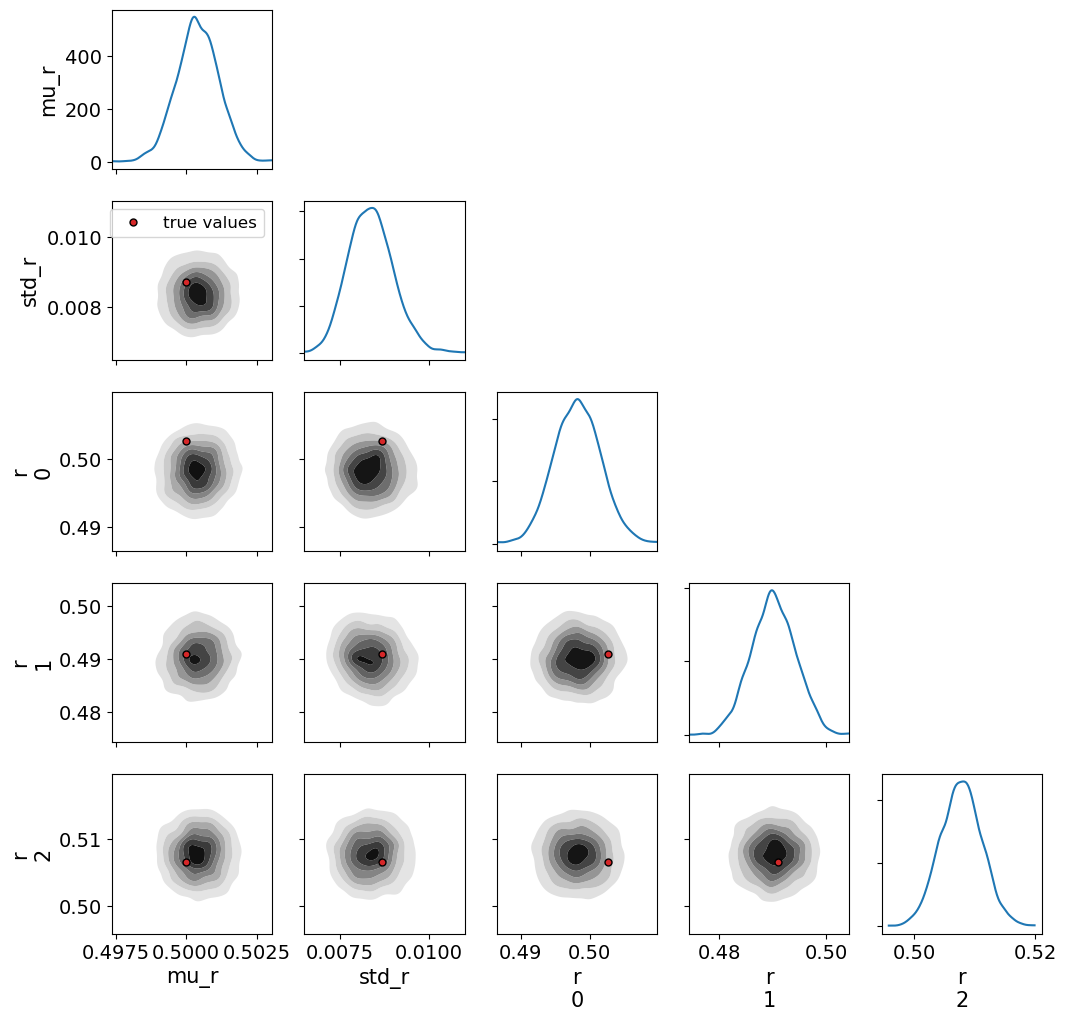

In [12]:
axes = az.plot_pair(
    samples,
    var_names=["mu_r", "std_r", "r"],
    marginals=True,
    kind="kde",
    kde_kwargs=dict(contourf_kwargs=dict(cmap="Greys"), contour_kwargs=dict(alpha=0.0)),
    figsize=(12, 12),
    reference_values={
        "mu_r": true_sc_dist.to_value(u.kpc),
        "std_r": true_sc_std.to_value(u.kpc),
        "r 0": true_sc_star_dist.to_value(u.kpc)[0],
        "r 1": true_sc_star_dist.to_value(u.kpc)[1],
        "r 2": true_sc_star_dist.to_value(u.kpc)[2]
    },
    reference_values_kwargs=dict(
        color="tab:red", markersize=5, label="true values", linestyle="none"
    ),
    coords={"r_dim_0": np.arange(3)}
)
axes[1, 0].legend(fontsize=12);

It looks like our model and sampling produces a posterior pdf that is consistent with the true values, so let's call that a success!

## Problem: Inferring the period distribution of low eccentricity binary stars

We are now going to move on to another demonstration of a hierarchical model with a little more complexity, using real data from the [APOGEE survey](https://www.sdss.org/dr17/), and you will do some of the implementation below.

The setup of this problem is that we would like to infer the (log)period distribution for low-eccentricity, close (short-period) binary-star systems given observations of radial velocities. These are all "SB1" systems, meaning that we assume that the spectra and radial velocity measurements correspond only to the primary star (i.e. the more luminous star) in the system. This is a common case when the primary is slightly evolved, or when the companion is a low-mass star — in these cases, the secondary star contributes negligibly to the spectra. 

### The data

The data are radial velocities $v_r$ measured at times $t$ (represented as JD's) and velocity uncertainties $\sigma_v$ from an updated catalog of binary-star systems produced as a follow-up to [Price-Whelan et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...895....2P/abstract). The dataset contains 14 unique sources, but 321 total velocity measurements (there are >12 velocity measurements per system). The times are given as Julian Date values (JD), and the velocities and uncertainties are given in km/s.

Let's load the data and make some initial visualizations:

In [13]:
apogee_data = at.Table.read('apogee-binaries.fits')
apogee_data[:3]

APOGEE_ID,JD,VHELIO,VHELIO_ERR
bytes23,float64,float64,float64
2M01282954+8522331,2455815.92103,-55.10033191342515,0.09070953988216654
2M01282954+8522331,2455822.93407,-67.73627799338021,0.10312443986234499
2M01282954+8522331,2455841.7649,-65.14283768577124,0.09059230018733438


As mentioned above, in the table, we have 14 unique systems, each with >12 radial velocity measurements:

In [14]:
uniq_ap_ids = np.unique(apogee_data['APOGEE_ID'])
len(uniq_ap_ids)

14

Let's visualize the velocity data:

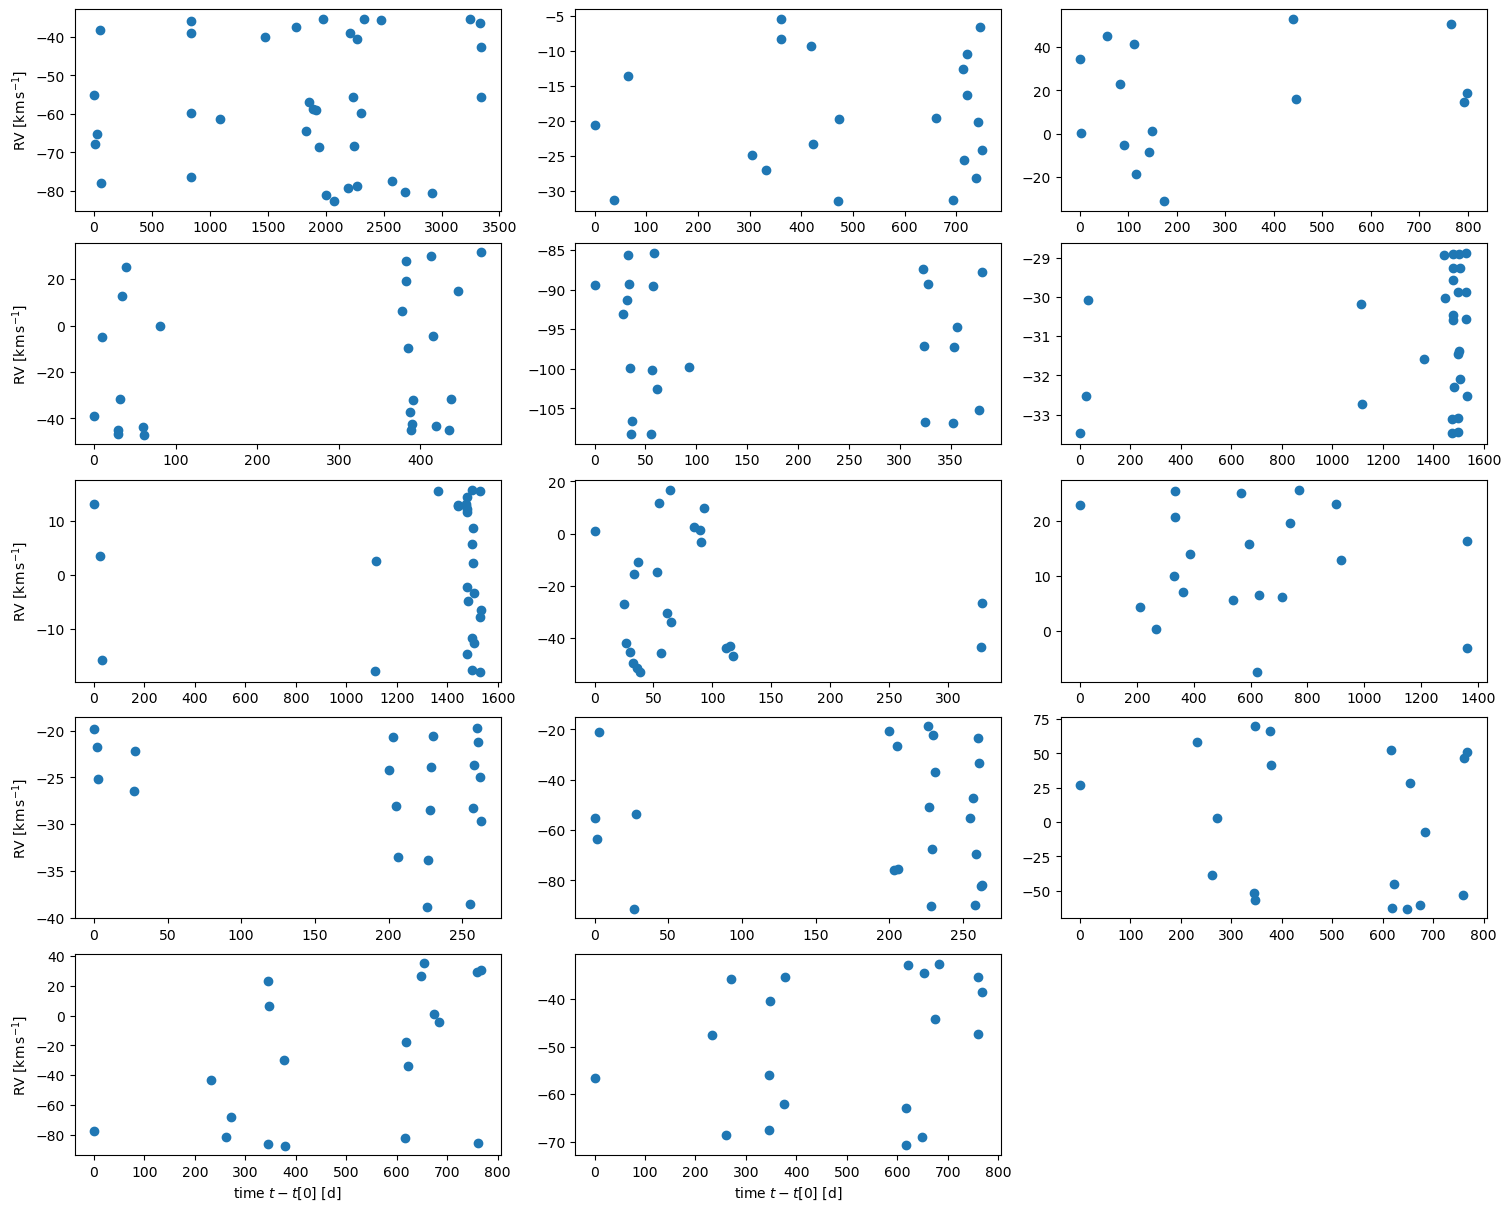

In [15]:
fig, axes = plt.subplots(5, 3, figsize=(15, 12), constrained_layout=True)

for ap_id, ax in zip(uniq_ap_ids, axes.flat):
    one_star_data = apogee_data[apogee_data['APOGEE_ID'] == ap_id]
    ax.errorbar(
        one_star_data['JD'] - one_star_data['JD'].min(),
        one_star_data['VHELIO'],
        one_star_data['VHELIO_ERR'],
        marker='o',
        ls='none'
    )
axes.flat[-1].set_visible(False)
    
for ax in axes[-1]:
    ax.set_xlabel('time $t - t[0]$ [d]')
for ax in axes[:, 0]:
    ax.set_ylabel(f'RV [{u.km/u.s:latex_inline}]');

Those all look like radial velocity-variable sources, but we will clearly need to do some modeling to determine the periods of these systems!

### Part 1: Infer the period of a single system

As a warm-up, let's start with a single system and construct a model to infer the orbital period.

Let's get the data for one of the objects from above, such as the first source:

In [16]:
one_star_data = apogee_data[apogee_data['APOGEE_ID'] == uniq_ap_ids[0]]
len(one_star_data)

36

This source has 36 velocity measurements, and the velocity data is already plotted in the upper left panel of the figure above. What model should we use to measure the period of the orbit? In general, when modeling radial velocity curves from two-body systems (e.g., star–star or star–planet systems), we should use Keplerian dynamics to construct a proper model for the radial velocity given period, eccentricity, and etc. (for example, using the [exoplanet](https://docs.exoplanet.codes/en/latest/) package or [thejoker](https://thejoker.rtfd.io/)). However, in this case, we have prior knowledge that these systems all have negligible eccentricities (i.e. very close to 0): Under this assumption, a good model for the velocities is a sinusoid with an overall offset (the mean velocity). With this setup, we have two choices:
1. We could fit a model like $v_r = a \, \cos\left(\frac{2\pi \, t}{P} + \phi \right) + v_0$, where $a$ is the amplitude, $P$ is the period, $\phi$ is a phase offset, and $v_0$ is the mean (systemic) velocity.
2. Equivalently, we could fit a model $v_r = a \, \cos\left(\frac{2\pi \, t}{P}\right) + b \, \sin\left(\frac{2\pi \, t}{P}\right) + v_0$, where $a$ and $b$ are amplitudes and all other parameters are the same.
These two models are different parametrizations of the same physical model for the data (a sinusoid), so how should we pick between them?

This relates to one of the trickiest and most important aspects of doing statistical inference in practice: choosing a good parametrization so that optimization and sampling is efficient and successful. We could spend an entire tutorial just talking about this, but we won't go into much detail about this here. For this particular example, we will choose the 2nd parametrization: A key difference between 1. and 2. above is that 1. has two linear parameters and two nonlinear parameters ($P$ and $\phi$), whereas 2. has three linear parameters and one nonlinear parameter ($P$). It is often a good idea to try to reduce the number of nonlinear parameters you have in a model because then certain marginalizations or integrals over your likelihood function may have closed form solutions (thus allowing you to reduce the number of parameters and speed up optimization or sampling).

With the parametrization 2. above, we have four parameters: $a, b, P, v_0$. The posterior pdf over these parameters given the observed $J$ radial velocities indexed by $j$ is:

$$
p(a, b, P, v_0 | \{v_r\}_J) \propto
    \left[ \prod_j^J p(v_r^{(j)} \,|\, a, b, P, v_0) \right] p(a) \,p(b) \,p(P) \, p(v_0)
$$

and the graphical model for this looks like:

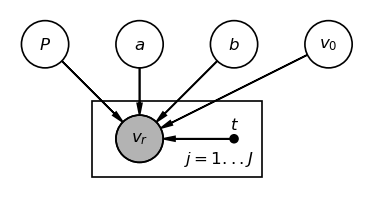

In [18]:
pgm = daft.PGM(dpi=120)

pgm.add_node("RV", r"$v_r$", 0, 0, observed=True)
pgm.add_node("t", r"$t$", 1, 0, fixed=True)

pgm.add_node("P", "$P$", -1, 1)
pgm.add_node("a", "$a$", 0, 1)
pgm.add_node("b", "$b$", 1, 1)
pgm.add_node("v_0", "$v_0$", 2, 1)

pgm.add_edge("P", "RV")
pgm.add_edge("a", "RV")
pgm.add_edge("b", "RV")
pgm.add_edge("v_0", "RV")
pgm.add_edge("t", "RV")

pgm.add_plate([-0.5, -0.4, 1.8, 0.8], label=r"$j = 1...J$", position="bottom right")

pgm.render();

With our data table in hand for one star (from the intro to Part 1 above), let's pull out the columns of data that we need:

In [19]:
t = one_star_data['JD'] - one_star_data['JD'].min()
rv = one_star_data['VHELIO']
rv_err = one_star_data['VHELIO_ERR']

We now want to find a good initialization (i.e. initial parameter value guesses) for the pymc sampler. For irregularly-spaced time series data, we can estimate the period using a [Lomb–Scargle Periodogram](https://iopscience.iop.org/article/10.3847/1538-4365/aab766). We can compute the frequency (period) of maximum power using [astropy's implementation](https://docs.astropy.org/en/stable/timeseries/lombscargle.html):

In [20]:
from astropy.timeseries import LombScargle

ls = LombScargle(t * u.day, rv, rv_err)

freq, power = ls.autopower(
    minimum_frequency=1/(20 * u.day), 
    maximum_frequency=1/(1.5 * u.day),
    samples_per_peak=10
)
init_P = (1 / freq[power.argmax()]).to_value(u.day)
print(init_P)

2.841198392949277


With an estimate of the period (our one nonlinear parameter), we can now use least-squares linear algebra to estimate initial guesses for our linear parameters $a, b, v_0$ (see the [Least-squares section of this blog post](https://adrian.pw/blog/fitting-a-line) for more information about this - we don't have time to dive in here!):

In [21]:
# Design matrix:
X = np.stack((
    np.cos(2*np.pi*t / init_P), 
    np.sin(2*np.pi*t / init_P),
    np.ones(len(t))
)).T

# Inverse covariance:
Cinv = np.diag(1 / rv_err**2)

# Least-squares optimal parameter values:
theta_best = np.linalg.solve(X.T @ Cinv @ X, X.T @ Cinv @ rv)

init_vals = {
    'P': init_P,
    'a': theta_best[0],
    'b': theta_best[1],
    'v0': theta_best[2]
}

**Task 1: Implement a Python function to evaluate the parametric model for the radial velocities that we defined above**

*Hint: We will want to be able to evaluate this function from within a pymc model and with regular numpy arrays, so allow passing in the math library as an argument `lib` to this function*

In [22]:
def rv_model(t, P, a, b, v0, lib=np):
    pass
    rv = a*np.cos(2*np.pi*t / P) + b*np.sin(2*np.pi*t / P) + v0 # WRITE CODE HERE
    return(rv)

**Task 2: Evaluate and plot this model over the data given the initial parameter values we defined above**

*Hint: The data span a wide range of times, so you wither want to zoom in the plot (with `xlim`) to show a few regions, or you can phase-fold the data and model using the initial period estimate*

(0.0, 100.0)

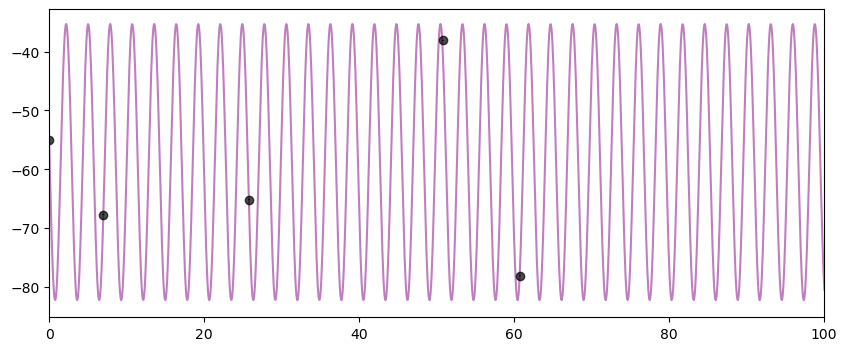

In [25]:
ts = np.linspace(t.min(), t.max(), 50000)
rvs = np.zeros_like(ts)
for i in range(len(ts)):
    rvs[i] = rv_model(ts[i], init_vals['P'], init_vals['a'], init_vals['b'], init_vals['v0'])
plt.figure(figsize=(10,4))
#phase = t_grid%init_P / init_P
plt.plot(ts, rvs, color='purple', alpha=0.5)
plt.errorbar(t, rv, rv_err, marker='o', ls='none', color='k', alpha=0.7)
plt.xlim(0, 100)

**Task 3: Define the pymc model and run the sampler**

Use a Uniform prior for the period between 1.5 and 20 days, and Normal priors for $a, b, v_0$ each centered at 0 (but you pick the standard deviations).

*Hint: When you define the model RV values, make sure to pass in `lib=pm.math` to your `rv_model` function*

In [26]:
def rv_model(t, P, a, b, v0, lib=np):
    pass
    rv = a*np.cos(2*np.pi*t / P) + b*np.sin(2*np.pi*t / P) + v0 # WRITE CODE HERE
    return(rv)

with pm.Model() as model1:
    # Leave this here: We want to store the value of the log-probability for later:
    pm.Deterministic('log_prob', model1.logp())
    P = pm.Uniform('P', 1.5, 20.0, initval=init_vals['P'])
    a = pm.Normal('a', 0, 100, initval=init_vals['a'])
    b = pm.Normal('b', 0, 100, initval=init_vals['b'])
    v0 = pm.Normal('v0', 0, 100, initval=init_vals['v0'])
    # WRITE CODE HERE:
    pass
    
    model_vr = rv_model(t, P, a, b, v0, lib=pm.math)
    
    pm.Normal('likelihood', model_vr,observed=rv,sigma=rv_err)
    
    # Leave this here: Run the sampler!
    samples1 = pm.sample(init='adapt_full')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/megannewsome/anaconda3/envs/DSFP/lib/python3.8/site-packages/pymc/step_methods/hmc/quadpotential.py:615: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P, a, b, v0]


/Users/megannewsome/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/megannewsome/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/megannewsome/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/megannewsome/anaconda3/envs/DSFP/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.922, but should be close to 0.8. Try to increase the number of tun

Assess the sampling: Does it look like it was successful?

In [70]:
az.summary(samples1, var_names=['P', 'a', 'b', 'v0'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,2.841,0.000,2.841,2.841,0.000,0.0,4189.0,2672.0,1.0
a,5.220,0.041,5.143,5.296,0.001,0.0,4087.0,2734.0,1.0
b,-22.748,0.025,-22.795,-22.701,0.000,0.0,4471.0,3025.0,1.0
v0,-58.796,0.015,-58.825,-58.768,0.000,0.0,4863.0,3140.0,1.0


We will now use arviz to pull out the maximum a posterior (MAP) sample from our chains: This is the value of the parameters that have the highest value of the log-posterior (and this is why we had to store the `model.logp()` value in the pymc model above):

In [71]:
stacked_samples = az.extract_dataset(samples1)
MAP_sample = stacked_samples.isel(sample=stacked_samples.log_prob.argmax())

We can now plot the data folded at the MAP period value, and over-plot the model at the MAP parameters:

(0.0, 2.8411439602895454)

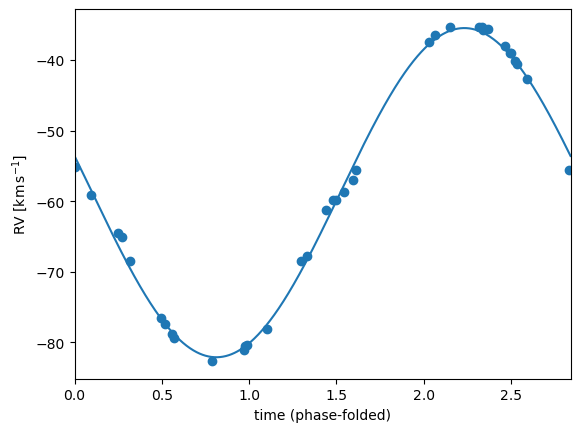

In [72]:
plt.errorbar(
    t % MAP_sample.P.values, 
    rv,
    rv_err,
    ls='none',
    marker='o'
)

t_grid = np.linspace(0, MAP_sample.P.values, 1024)
model_rv = rv_model(
    t_grid, 
    MAP_sample.P.values,
    MAP_sample.a.values,
    MAP_sample.b.values, 
    MAP_sample.v0.values,
)
plt.plot(t_grid, model_rv, marker='', color='tab:blue', zorder=-1)

plt.xlabel('time (phase-folded)')
plt.ylabel(f'RV [{u.km/u.s:latex_inline}]')
plt.xlim(0, MAP_sample.P.values)

We have now successfully built a one-level model for the period (and other parameters) of a single system - congrats! Our task now is to extend this to a multi-level (hierarchical) model in which we also infer the period distribution parameters for the population of 14 binary star systems.

### Part 2: Infer the log-period distribution

We now need to generalize the pymc model we used above to include parameters that control the (log)period distribution (i.e. make the parameters of the period prior themselves random variables). We then have to loop over the 14 unique sources we have and add period, amplitude, and mean velocity parameters for each object. One change we will make compared to the single-source model is that here we will fit for the parameters of the log-period instead of the period, so you should work in $\ln P$ and transform this to $P$ when calling our `rv_model()` function.

Let's first look at a PGM for this model, where $n$ indexes the $N=14$ systems and $j$ indexes the $J_n$ radial velocity measurements per system:

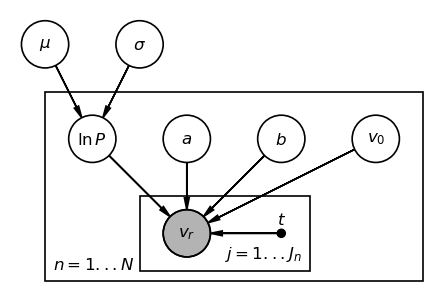

In [73]:
pgm = daft.PGM(dpi=120)

pgm.add_node("RV", r"$v_r$", 0, 0, observed=True)
pgm.add_node("t", r"$t$", 1, 0, fixed=True)

pgm.add_node("lnP", "$\ln P$", -1, 1)
pgm.add_node("a", "$a$", 0, 1)
pgm.add_node("b", "$b$", 1, 1)
pgm.add_node("v_0", "$v_0$", 2, 1)

pgm.add_node("mu", r"$\mu$", -1.5, 2)
pgm.add_node("std", r"$\sigma$", -0.5, 2)

pgm.add_edge("lnP", "RV")
pgm.add_edge("a", "RV")
pgm.add_edge("b", "RV")
pgm.add_edge("v_0", "RV")
pgm.add_edge("t", "RV")
pgm.add_edge("mu", "lnP")
pgm.add_edge("std", "lnP")

pgm.add_plate([-1.5, -0.5, 4, 2], label=r"$n = 1...N$", position="bottom left")
pgm.add_plate([-0.5, -0.4, 1.8, 0.8], label=r"$j = 1...J_n$", position="bottom right")

pgm.render();

In your definition of the model, you will need to get initial values for the period, amplitudes, and mean velocity as we did above. It will therefore be useful to have a Python function that takes in three arrays (time, radial velocity, and radial velocity uncertainty) and returns a dictionary of initial guesses for $P, a, b, v0$. 

**Task 1: Implement a function that takes in RV data for one source and returns initial guesses for its parameters**

In [75]:
from astropy.timeseries import LombScargle

def get_init_vals(t, rv, rv_err):
    pass
    
    ls = LombScargle(t * u.day, rv, rv_err)

    freq, power = ls.autopower(
        minimum_frequency=1/(20 * u.day), 
        maximum_frequency=1/(1.5 * u.day),
        samples_per_peak=10 )
    init_P = (1 / freq[power.argmax()]).to_value(u.day)
    
    X = np.stack((
    np.cos(2*np.pi*t / init_P), 
    np.sin(2*np.pi*t / init_P),
    np.ones(len(t))
    )).T

    # Inverse covariance:
    Cinv = np.diag(1 / rv_err**2)

    # Least-squares optimal parameter values:
    theta_best = np.linalg.solve(X.T @ Cinv @ X, X.T @ Cinv @ rv)
    
    init_vals = {
             'P': init_P,
             'a': theta_best[0],
             'b': theta_best[1],
             'v0': theta_best[2]
             }
    
    return init_vals

**Task 2: Define a pymc model for the hierarchical model over the log-period distribution of these binary-star systems**

Use a Gaussian (`Normal()`) with hyperparameters mean $\mu$ and standard deviation $\sigma$ to model the log-period distribution.

*Hint: You can loop over source ID's (as we did above to make the plot of all RV data) and define parameters inside of the loop - pymc will keep track of them! Just make sure to give the parameters unique names, like 'lnP_1', 'lnP_2', etc. for each system in our sample.*

In [80]:
with pm.Model() as model2:    
    # Write code here!
    pass
    lnsigma = pm.Normal('lnsigma', -3, 3)
    lnmu = pm.Normal('lnmu', 0.0, 1.0)
    sigma = pm.math.exp(lnsigma)
    mu = pm.math.exp(lnmu)
    
    for n in range(len(uniq_ap_ids)):
        one_star_data = apogee_data[apogee_data['APOGEE_ID'] == ap_id]
        t = one_star_data['JD'] - one_star_data['JD'].min()
        rv = one_star_data['VHELIO']
        rv_err = one_star_data['VHELIO_ERR']
        init_vals = get_init_vals(t, rv, rv_err)
        
        lnP = pm.Normal(f'lnP[{n}]', np.log(1.5), np.log(20.0), initval=np.log(init_vals['P']))
        a = pm.Normal(f'a[{n}]', 0, 100, initval=init_vals['a'])
        b = pm.Normal(f'b[{n}]', 0, 100, initval=init_vals['b'])
        v0 = pm.Normal(f'v0[{n}]', 0, 100, initval=init_vals['v0'])
        
        model2 = rv_model(t, pm.math.exp(lnP), a, b, v0, lib=pm.math)
    
        pm.Normal(
            f'likelihood[{n}]', 
            model2,
            observed=rv,
            sigma=rv_err
            )
    
    # Leave this here: We want to store the value of the log-probability for later:
    pm.Deterministic('log_prob', model2.logp())
    
    # Leave this here: Run the sampler!
    samples2 = pm.sample(init='adapt_diag')

AttributeError: 'TensorVariable' object has no attribute 'logp'

**Task 3: Assess the sampling**

Did the sampling succeed? Make a corner plot (`az.plot_pair()`) of the hyperparameters of the log-period distribution. What is the mean log-period we infer?

In [ ]:
az.summary(samples2, var_names=['mu', 'lnsigma'])

In [ ]:
az.plot_pair(samples2, var_names=['mu', 'lnsigma'], figsize=(5, 5))

## Recap and Other Resources

Well done! In this tutorial, we learned about *hierarchical models* and implemented a multi-level model to infer the log-period distribution of binary-star systems with real data from the APOGEE surveys. The concepts we discussed here should serve as building blocks that you can put together and extend into much more complex inference problems. There are many examples of hierarchical models in the (recent) astronomical literature, but here are a few papers that span a range of domain topics:
- [A Probabilistic Approach to Fitting Period-luminosity Relations and Validating Gaia Parallaxes](https://ui.adsabs.harvard.edu/abs/2017ApJ...838..107S/abstract)
- [Hierarchical Modeling and Statistical Calibration for Photometric Redshifts](https://ui.adsabs.harvard.edu/abs/2019ApJ...881...80L/abstract)
- [Hierarchical Probabilistic Inference of the Color-Magnitude Diagram and Shrinkage of Stellar Distance Uncertainties
](https://ui.adsabs.harvard.edu/abs/2017AJ....154..222L/abstract)
- [Comparing Bayes factors and hierarchical inference for testing general relativity with gravitational waves
](https://ui.adsabs.harvard.edu/abs/2022PhRvD.106b4048I/abstract)
- [Bayesian forward modelling of cosmic shear data](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.3035P/abstract)